#Procesamiento del lenguaje
## Caso Pr√°ctico 2: Representaci√≥n de texto

Integrantes:

Amagua Luis

Edwin Simba√±a


### Descripci√≥n de la actividad:

Con base en los elementos estudiados en la Unidad 2, elabore un notebook o un proyecto, utilizando las herramientas explicadas por su profesor, en el que se usen al menos dos de los m√©todos de representaci√≥n de texto estudiadas en la asignatura. Como estrategia de desarrollo, considere los siguientes pasos:

1. Revisar las diferentes t√©cnicas de representaci√≥n de texto estudiadas en el apartado 2.2 de la gu√≠a.

2. Revisar el caso de referencia Text-Representations para adaptar o reusar el c√≥digo para la representaci√≥n de texto.

3. Elaborar el notebook o proyecto seleccionando una de las herramientas o librer√≠as disponibles. Para la aplicaci√≥n de los m√©todos de representaci√≥n de texto considere los siguientes recursos:

 a. Corpus de textos: dataset de rese√±as de productos, disponible en este enlace.

 b. Archivo de enunciado de la tarea: El desarrollo deber√° considerar la soluci√≥n a cada uno de los ejercicios planteados en el enunciado.

4. En el link de la tarea, subir el notebook (en formato html) o proyecto creado para dar soluci√≥n a los puntos planteados en el archivo de enunciado de la tarea.


El dataset que se va analizar, https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022

In [1]:
#!pip install preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #muestra estratificada
from sklearn.feature_extraction.text import TfidfVectorizer #TD-IDF
import re
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
# Cargar el dataset
df = pd.read_csv('/content/reviews_Spotify.csv')

# Usar train_test_split para obtener solo la muestra de entrenamiento
df_sample, _ = train_test_split(df, train_size=6000, stratify=df['Rating'], random_state=42)
df_sample = pd.DataFrame(df_sample)


In [4]:
# Verificar el tama√±o y las primeras filas
print(df_sample.shape)
print(df_sample.head())

(6000, 5)
            Time_submitted                                             Review  \
33934  2022-04-17 01:03:12  Hi Spotify, Lately when I play a music in Spot...   
3709   2022-07-01 10:41:10  It's amazing. One thing is needed that those w...   
14918  2022-06-04 15:26:19  So easy to use. Love the suggested play lists ...   
49640  2022-02-25 21:30:13  The new update is TRASH! I tried to play my pl...   
60838  2022-01-12 14:22:56  It's such a good app I just lüíúVE it i'm and ar...   

       Rating  Total_thumbsup Reply  
33934       4               0   NaN  
3709        5               0   NaN  
14918       5               0   NaN  
49640       1               1   NaN  
60838       5              14   NaN  


# Categorizaci√≥n de la variable Rating
Se categorizar√°n los valores de 'Rating' de la siguiente forma:

1. Se retiran los valores correspondientes a 0, pues representan valores neutros.

2. Los valores de 'Rating' correspondientes a 4 y 5 se asignan como 1.

3. Los valores de 'Rating' correspondientes a 1 y 2 se asignan como 0.

In [5]:
df_sample['sentimiento']=df_sample['Rating'].apply(lambda x: 1 if x>=4 else 0 if x<=2 else 0)
df_sample = df_sample[df_sample['Rating'] != 3]

print(df_sample.shape)
df_sample.head()

(5329, 6)


Time_submitted                                             Review  \
33934  2022-04-17 01:03:12  Hi Spotify, Lately when I play a music in Spot...   
3709   2022-07-01 10:41:10  It's amazing. One thing is needed that those w...   
14918  2022-06-04 15:26:19  So easy to use. Love the suggested play lists ...   
49640  2022-02-25 21:30:13  The new update is TRASH! I tried to play my pl...   
60838  2022-01-12 14:22:56  It's such a good app I just lüíúVE it i'm and ar...   

       Rating  Total_thumbsup Reply  sentimiento  
33934       4               0   NaN            1  
3709        5               0   NaN            1  
14918       5               0   NaN            1  
49640       1               1   NaN            0  
60838       5              14   NaN            1

## An√°lsisis Exploratorio

Se tienen 5.329 registros y se realizar√° un an√°lisis exploratorio de datos.

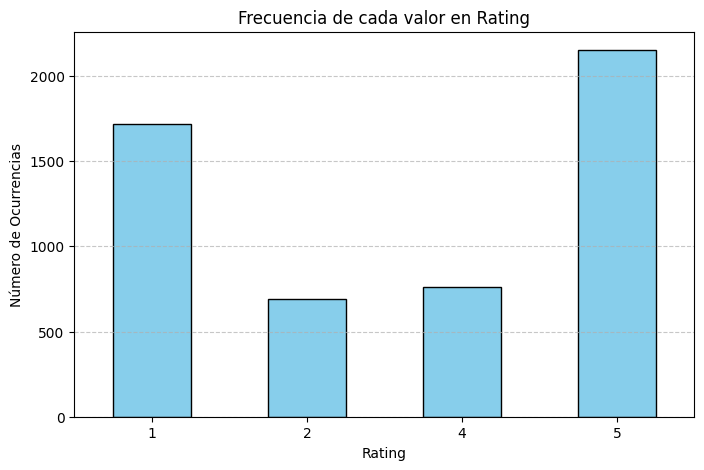

In [6]:
# Contar la frecuencia de cada valor en la columna 'Rating'
frecuencia = df_sample['Rating'].value_counts().sort_index()  # Usamos sort_index() para ordenar los valores

# Graficar el resultado como un gr√°fico de barras
plt.figure(figsize=(8, 5))
frecuencia.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frecuencia de cada valor en Rating')
plt.xlabel('Rating')
plt.ylabel('N√∫mero de Ocurrencias')
plt.xticks(rotation=0)  # Mantener las etiquetas del eje X en posici√≥n horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

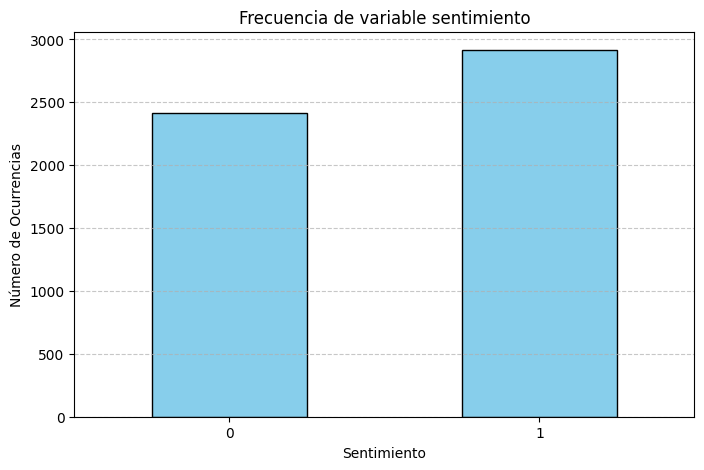

In [7]:
# Contar la frecuencia de cada valor en la columna 'Rating'
frecuencia = df_sample['sentimiento'].value_counts().sort_index()  # Usamos sort_index() para ordenar los valores

# Graficar el resultado como un gr√°fico de barras
plt.figure(figsize=(8, 5))
frecuencia.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frecuencia de variable sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('N√∫mero de Ocurrencias')
plt.xticks(rotation=0)  # Mantener las etiquetas del eje X en posici√≥n horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
print(df_sample['Time_submitted'].min())
print(df_sample['Time_submitted'].max())

# se tienen datos del 1 de enero de 2022 a 9 de julio de 2022, es decir datos de 8 meses.

2022-01-01 03:01:29
2022-07-09 13:10:50


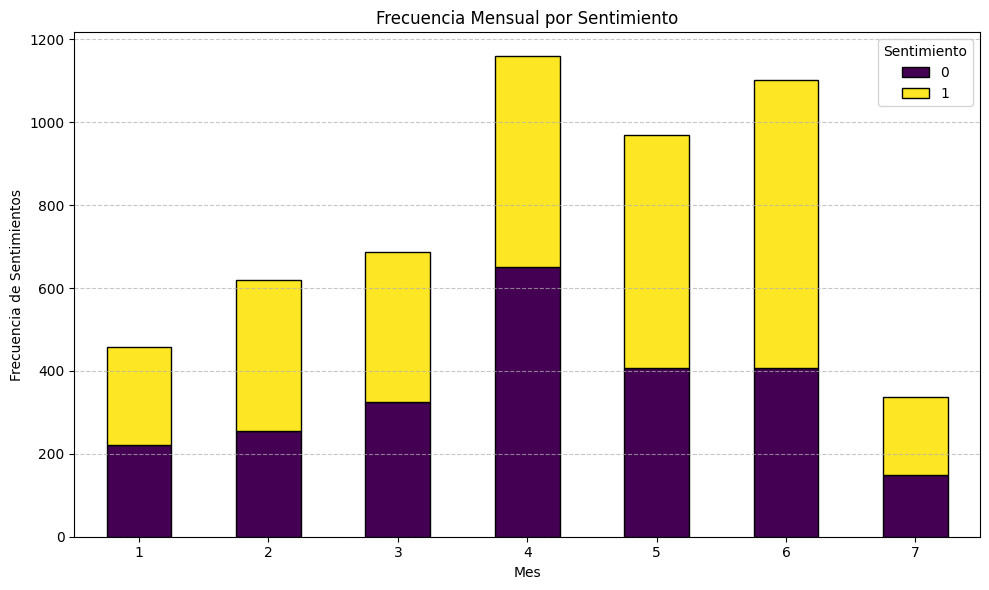

In [9]:
# agregar mes al dataframe
df_sample['Time_submitted'] = pd.to_datetime(df_sample['Time_submitted'])
df_sample['Mes'] = df_sample['Time_submitted'].dt.month

# Contar la frecuencia de cada sentimiento por mes
df_mensual = df_sample.groupby(['Mes', 'sentimiento']).size().unstack(fill_value=0)

# Crear el gr√°fico de barras apiladas
plt.figure(figsize=(10, 6))
df_mensual.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black', ax=plt.gca())
plt.title('Frecuencia Mensual por Sentimiento')
plt.xlabel('Mes')
plt.ylabel('Frecuencia de Sentimientos')
plt.xticks(rotation=0)
plt.legend(title='Sentimiento')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Limpieza de datos

In [10]:
# Convertir el texto en min√∫sculas
df_sample['Review'] = df_sample['Review'].apply(lambda x: x.lower())

In [11]:
#Eliminar signos de puntuaci√≥n:
PUNCTUATION = """!"#$%&()*+,-./:;<=>?@[\]^_`{|}~"""

def remove_punctuation(text):
    for punctuation in PUNCTUATION:
        text = text.replace(punctuation, '')
    return text

df_sample['Review']= df_sample['Review'].apply(remove_punctuation)

# eliminar emojis
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # S√≠mbolos y pictogramas
        u"\U0001F680-\U0001F6FF"  # Transportes y s√≠mbolos de mapa
        u"\U0001F1E0-\U0001F1FF"  # Banderas (iOS)
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

df_sample['Review']= df_sample['Review'].apply(remove_emoji)


# Lista de contracciones y sus equivalentes
contraction_patterns = [
    (r"won't", 'will not'), (r"can't", 'cannot'), (r"i'm", 'i am'), (r"ain't", 'is not'),
    (r"(\w+)'ll", r"\g<1> will"), (r"(\w+)n't", r"\g<1> not"),
    (r"(\w+)'ve", r"\g<1> have"), (r"(\w+)'s", r"\g<1> is"), (r"(\w+)'re", r"\g<1> are"),
    (r"(\w+)'d", r"\g<1> would"), (r"&", 'and'), (r"dammit", 'damn it'), (r"dont", 'do not'), (r"wont", 'will not')
]

def replace_strings(text, patterns):
    for pattern, replacement in patterns:
        text = re.sub(pattern, replacement, text)
    return text

patterns = [(re.compile(regex), repl) for regex, repl in contraction_patterns]

df_sample['Review'] = df_sample['Review'].apply(lambda x: replace_strings(x, patterns))

df_sample.head()

Time_submitted                                             Review  \
33934 2022-04-17 01:03:12  hi spotify lately when i play a music in spoti...   
3709  2022-07-01 10:41:10  it is amazing one thing is needed that those w...   
14918 2022-06-04 15:26:19  so easy to use love the suggested play lists too    
49640 2022-02-25 21:30:13  the new update is trash i tried to play my pla...   
60838 2022-01-12 14:22:56  it is such a good app i just lve it i am and a...   

       Rating  Total_thumbsup Reply  sentimiento  Mes  
33934       4               0   NaN            1    4  
3709        5               0   NaN            1    7  
14918       5               0   NaN            1    6  
49640       1               1   NaN            0    2  
60838       5              14   NaN            1    1

In [12]:
df['Review']

0        Great music service, the audio is high quality...
1        Please ignore previous negative rating. This a...
2        This pop-up "Get the best Spotify experience o...
3          Really buggy and terrible to use as of recently
4        Dear Spotify why do I get songs that I didn't ...
                               ...                        
61589    Even though it was communicated that lyrics fe...
61590    Use to be sooo good back when I had it, and wh...
61591    This app would be good if not for it taking ov...
61592    The app is good hard to navigate and won't jus...
61593    Its good but sometimes it doesnt load the musi...
Name: Review, Length: 61594, dtype: object

### Wordcloud

In [13]:
import nltk
from nltk.corpus import stopwords

# Descargar stopwords si no est√°n descargadas
nltk.download('stopwords')

# Lista de stopwords (palabras vac√≠as)
STOPWORDS = stopwords.words('english')
STOPWORDS = STOPWORDS + ['hi', 'ok', 'u', 'well', 'oh', 'ltgt']

# Funci√≥n para eliminar las stopwords directamente desde el texto
def remove_stopwords_from_text(text, stopwords_list):
    # Convertir el texto a min√∫sculas, separar en palabras y eliminar stopwords
    return ' '.join([word for word in text.split() if word.lower() not in stopwords_list])

# Aplicar la funci√≥n al DataFrame
df_sample['Review'] = df_sample['Review'].apply(lambda x: remove_stopwords_from_text(x, STOPWORDS))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


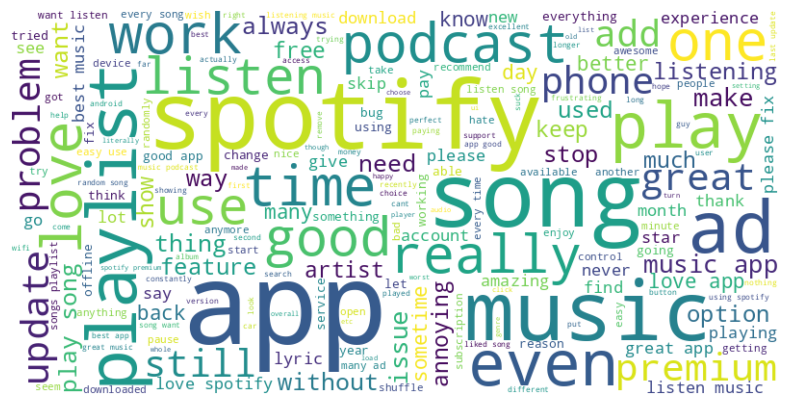

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Visualizar nube de palabras del texto original:
def viz_wordcloud(text):
    # Crear el objeto WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Mostrar la nube de palabras utilizando matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Unir todas las rese√±as en un solo texto, sin tokenizar
stream = ' '.join(df_sample['Review'].dropna()) # Aseg√∫rate de quitar los valores NaN

# Visualizar la nube de palabras
viz_wordcloud(stream)


## Tokenizaci√≥n

In [20]:
import nltk
nltk.download('punkt') # Paquete que contiene los tokenizadores
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [21]:
from nltk.tokenize import word_tokenize

# usar word_tokenize para tokenizar texto:
df_sample['tokenized_text']= df_sample['Review'].apply(lambda x: word_tokenize(x))
df_sample.head()

Time_submitted                                             Review  \
33934 2022-04-17 01:03:12  spotify lately play music spotify app play bar...   
3709  2022-07-01 10:41:10  amazing one thing needed get premium cannot do...   
14918 2022-06-04 15:26:19                 easy use love suggested play lists   
49640 2022-02-25 21:30:13  new update trash tried play playlist played ra...   
60838 2022-01-12 14:22:56  good app lve army kpop fan listen song clearly...   

       Rating  Total_thumbsup Reply  sentimiento  Mes  \
33934       4               0   NaN            1    4   
3709        5               0   NaN            1    7   
14918       5               0   NaN            1    6   
49640       1               1   NaN            0    2   
60838       5              14   NaN            1    1   

                                          tokenized_text  
33934  [spotify, lately, play, music, spotify, app, p...  
3709   [amazing, one, thing, needed, get, premium, ca...  
14918          [easy, use, love, suggested, play, lists]  
49640  [new, update, trash, tried, play, playlist, pl...  
60838  [good, app, lve, army, kpop, fan, listen, song...

### lematizacion

In [22]:
!pip install stanza
!pip install spacy_stanza

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.1/1.1 MB 21.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 586.9/586.9 kB 26.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 881.2/881.2 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: stanza
    Found existing installation: stanza 1.9.2
    Uninstalling stanza-1.9.2:
      Successfully uninstalled stanza-1.9.2


In [23]:
import stanza
import spacy_stanza

# Download the stanza model if necessary
#stanza.download("es")

# Initialize the pipeline
nlp = spacy_stanza.load_pipeline("es", processors='tokenize,pos,lemma', tokenize_pretokenized = True, verbose=False, use_gpu=False)

/usr/local/lib/python3.10/dist-packages/stanza/models/pos/trainer.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, lambda storage, loc

In [24]:
df_sample['norm_text'] = df_sample['tokenized_text'].apply(lambda x: nlp(' '.join(x)))

In [25]:
df_sample.head()

Time_submitted                                             Review  \
33934 2022-04-17 01:03:12  spotify lately play music spotify app play bar...   
3709  2022-07-01 10:41:10  amazing one thing needed get premium cannot do...   
14918 2022-06-04 15:26:19                 easy use love suggested play lists   
49640 2022-02-25 21:30:13  new update trash tried play playlist played ra...   
60838 2022-01-12 14:22:56  good app lve army kpop fan listen song clearly...   

       Rating  Total_thumbsup Reply  sentimiento  Mes  \
33934       4               0   NaN            1    4   
3709        5               0   NaN            1    7   
14918       5               0   NaN            1    6   
49640       1               1   NaN            0    2   
60838       5              14   NaN            1    1   

                                          tokenized_text  \
33934  [spotify, lately, play, music, spotify, app, p...   
3709   [amazing, one, thing, needed, get, premium, ca...   
14918          [easy, use, love, suggested, play, lists]   
49640  [new, update, trash, tried, play, playlist, pl...   
60838  [good, app, lve, army, kpop, fan, listen, song...   

                                               norm_text  
33934  (spotify, lately, play, music, spotify, app, p...  
3709   (amazing, one, thing, needed, get, premium, ca...  
14918          (easy, use, love, suggested, play, lists)  
49640  (new, update, trash, tried, play, playlist, pl...  
60838  (good, app, lve, army, kpop, fan, listen, song...


## Modelo espacio-vectorial Vectorizador TF-IDF

In [26]:
tfidf = TfidfVectorizer(stop_words='english',
                        max_df=0.85,        # Ignora t√©rminos que aparecen en m√°s del 85% de los documentos
                        max_features=500,   # Limitar a las 500 palabras m√°s relevantes
                        ngram_range=(1, 2)  # Considerar bigramas adem√°s de palabras individuales
                        )

# Extraer la columna de 'Review' en una lista
reviews = df_sample['tokenized_text'].apply(lambda x: ' '.join(x)).fillna('')  # Asegurarte de que no haya valores nulos

# Transformar los textos a una matriz TF-IDF
data_vector = tfidf.fit_transform(reviews).toarray()

# Convertir el resultado en un DataFrame, si lo deseas, con las palabras como columnas
data_vector_df = pd.DataFrame(data_vector, columns=tfidf.get_feature_names_out())

# Opcional: Mostrar una parte del DataFrame resultante
print(data_vector_df)

       10   30  30 minutes  able  absolutely  access  account  actually   ad  \
0     0.0  0.0         0.0   0.0         0.0     0.0      0.0       0.0  0.0   
1     0.0  0.0         0.0   0.0         0.0     0.0      0.0       0.0  0.0   
2     0.0  0.0         0.0   0.0         0.0     0.0      0.0       0.0  0.0   
3     0.0  0.0         0.0   0.0         0.0     0.0      0.0       0.0  0.0   
4     0.0  0.0         0.0   0.0         0.0     0.0      0.0       0.0  0.0   
...   ...  ...         ...   ...         ...     ...      ...       ...  ...   
5324  0.0  0.0         0.0   0.0         0.0     0.0      0.0       0.0  0.0   
5325  0.0  0.0         0.0   0.0         0.0     0.0      0.0       0.0  0.0   
5326  0.0  0.0         0.0   0.0         0.0     0.0      0.0       0.0  0.0   
5327  0.0  0.0         0.0   0.0         0.0     0.0      0.0       0.0  0.0   
5328  0.0  0.0         0.0   0.0         0.0     0.0      0.0       0.0  0.0   

      ad free  ...  works  world     wo

In [28]:
print(data_vector_df.shape)

(5329, 500)


## Modelo probabil√≠stico de t√≥picos (LDA)

In [136]:
# Obtener cadenas transformadas del texto:
transformed_sentences = df_sample['tokenized_text'].apply(lambda x: ' '.join(x)).fillna('')  # unir todos los tokens de un mensaje en un solo string

transformed_sentences[:5]

33934    spotify lately play music spotify app play bar...
3709     amazing one thing needed get premium can not d...
14918                   easy use love suggested play lists
49640    new update trash tried play playlist played ra...
60838    good app lve army kpop fan listen song clearly...
Name: tokenized_text, dtype: object

In [138]:
nltk.download('averaged_perceptron_tagger_eng')

from nltk import pos_tag, word_tokenize

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [139]:
def get_noun_and_collocation(sentence):
    nouns_and_collocations = []
    noun_tags = ['NN', 'NNS']
    tokens_pos_tagged = pos_tag(word_tokenize(sentence))
    for tpos in tokens_pos_tagged:
        if '_' in tpos[0]:
            nouns_and_collocations.append(tpos[0])
        elif tpos[1] in noun_tags:
            nouns_and_collocations.append(tpos[0])
    return nouns_and_collocations

noun_stream = [get_noun_and_collocation(email) for email in transformed_sentences]

noun_stream[:5]

[['music', 'spotify', 'play', 'bar', 'issue', 'resolve', 'galaxy', 'ui'],
 ['thing', 'get', 'premium', 'music', 'download', 'premium', 'spotify'],
 ['use', 'love', 'play', 'lists'],
 ['trash',
  'playlist',
  'random',
  'song',
  'reason',
  'songs',
  'playlist',
  'songs',
  'needs',
  'right'],
 ['app',
  'army',
  'kpop',
  'fan',
  'listen',
  'song',
  'quality',
  'data',
  'app',
  'drawback',
  'ads',
  'songs',
  'app']]

In [140]:
!pip install gensim

In [141]:
import gensim
import gensim.corpora as corpora

num_topics = 10
dictionary = corpora.Dictionary(noun_stream)
corpus = [dictionary.doc2bow(text) for text in noun_stream]
ldamodel = gensim.models.ldamodel.LdaModel(corpus,
                                               num_topics=num_topics,
                                               random_state=1,
                                               id2word = dictionary)

ldamodel.print_topics(num_topics= num_topics, num_words=10)

[(0,
  '0.062*"spotify" + 0.028*"app" + 0.026*"music" + 0.018*"work" + 0.016*"play" + 0.015*"time" + 0.013*"podcast" + 0.012*"songs" + 0.012*"love" + 0.010*"experience"'),
 (1,
  '0.137*"app" + 0.124*"music" + 0.021*"time" + 0.015*"love" + 0.014*"please" + 0.014*"play" + 0.012*"fix" + 0.011*"use" + 0.011*"playlists" + 0.011*"spotify"'),
 (2,
  '0.144*"songs" + 0.043*"music" + 0.042*"app" + 0.022*"song" + 0.022*"spotify" + 0.019*"lyrics" + 0.019*"playlist" + 0.017*"ads" + 0.017*"playlists" + 0.011*"play"'),
 (3,
  '0.093*"songs" + 0.056*"premium" + 0.048*"app" + 0.033*"music" + 0.029*"ads" + 0.019*"play" + 0.015*"playlist" + 0.015*"year" + 0.014*"spotify" + 0.014*"song"'),
 (4,
  '0.081*"song" + 0.064*"music" + 0.026*"spotify" + 0.024*"app" + 0.018*"playlist" + 0.015*"search" + 0.014*"day" + 0.014*"podcasts" + 0.013*"choose" + 0.011*"try"'),
 (5,
  '0.090*"song" + 0.041*"app" + 0.038*"play" + 0.037*"songs" + 0.027*"phone" + 0.025*"playlist" + 0.019*"music" + 0.016*"update" + 0.013*"prob

### Visualizaci√≥n

In [154]:
!pip install --upgrade pip setuptools wheel
!pip install scikit-learn
!pip install pyLDAvis

  Using cached setuptools-75.4.0-py3-none-any.whl.metadata (6.8 kB)
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.8/1.8 MB 29.8 MB/s eta 0:00:00
Using cached setuptools-75.4.0-py3-none-any.whl (1.2 MB)
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 72.5/72.5 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.44.0
    Uninstalling wheel-0.44.0:
      Successfully uninstalled wheel-0.44.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are

  Using cached funcy-2.0-py2.py3-none-any.whl.metadata (5.9 kB)
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.6/2.6 MB 39.2 MB/s eta 0:00:00


In [155]:
import pyLDAvis
import sklearn

print("pyLDAvis version:", pyLDAvis.__version__)
print("scikit-learn version:", sklearn.__version__)

pyLDAvis version: 3.4.0
scikit-learn version: 1.5.2


In [156]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
gensimvis.prepare(ldamodel, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.029801  0.013877       1        1  16.062742
2      0.012274 -0.083427       2        1  12.695011
3      0.055956 -0.050785       3        1  11.045286
6      0.069212  0.030509       4        1  10.798400
5      0.006292 -0.151168       5        1  10.661927
0      0.018393  0.072903       6        1  10.146982
8      0.076152  0.065179       7        1   9.304079
7      0.031396  0.099100       8        1   8.965388
4     -0.088004 -0.051170       9        1   5.944080
9     -0.211473  0.054982      10        1   4.376106, topic_info=         Term         Freq        Total Category  logprob  loglift
21      songs  1425.000000  1425.000000  Default  30.0000  30.0000
20       song   878.000000   878.000000  Default  29.0000  29.0000
23        ads   706.000000   706.000000  Default  28.0000  28.0000
105  podcasts   222.000000   222.000000  Default  27.0000  27.0000
10    premium   379.000000   379.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
78     thanks     9.835333    79.643212  Topic10  -5.0482   1.0374
110   control     8.749847    52.760099  Topic10  -5.1652   1.3323
331    access     9.291055    79.046117  Topic10  -5.1052   0.9880
415       way     9.375336   209.607444  Topic10  -5.0961   0.0219
6     spotify     8.585667   718.107946  Topic10  -5.1841  -1.2975

[722 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
331       1  0.126508   access
331       3  0.139159   access
331       4  0.151810   access
331       6  0.050603   access
331       7  0.227715   access
...     ...       ...      ...
420       8  0.285655  youtube
420       9  0.090890  youtube
2213      6  0.933059      yrs
2181      5  0.926620     zero
2101      9  0.703308        ‚ú®

[1752 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 7, 6, 1, 9, 8, 5, 10])

## Vectorizar palabras y t√©rminos con Word2Vec.


In [174]:
df_sample['norm_text_word2vec'] = df_sample['norm_text'].apply(lambda x: [token.lemma_ for token in x])
df_sample.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Time_submitted                                             Review  \
33934 2022-04-17 01:03:12  spotify lately play music spotify app play bar...   
3709  2022-07-01 10:41:10  amazing one thing needed get premium cannot do...   
14918 2022-06-04 15:26:19                 easy use love suggested play lists   
49640 2022-02-25 21:30:13  new update trash tried play playlist played ra...   
60838 2022-01-12 14:22:56  good app lve army kpop fan listen song clearly...   

       Rating  Total_thumbsup Reply  sentimiento  Mes  \
33934       4               0   NaN            1    4   
3709        5               0   NaN            1    7   
14918       5               0   NaN            1    6   
49640       1               1   NaN            0    2   
60838       5              14   NaN            1    1   

                                          tokenized_text  \
33934  [spotify, lately, play, music, spotify, app, p...   
3709   [amazing, one, thing, needed, get, premium, ca...   
14918          [easy, use, love, suggested, play, lists]   
49640  [new, update, trash, tried, play, playlist, pl...   
60838  [good, app, lve, army, kpop, fan, listen, song...   

                                               norm_text  \
33934  (spotify, lately, play, music, spotify, app, p...   
3709   (amazing, one, thing, needed, get, premium, ca...   
14918          (easy, use, love, suggested, play, lists)   
49640  (new, update, trash, tried, play, playlist, pl...   
60838  (good, app, lve, army, kpop, fan, listen, song...   

                                      norm_text_word2vec  
33934  [spotify, lately, play, music, spotify, app, p...  
3709   [amazing, one, thing, needed, get, premium, ca...  
14918         [easy, usar, love, suggested, play, lists]  
49640  [new, update, trash, tried, play, playlist, pl...  
60838  [good, app, lve, army, kpop, fan, listen, song...

In [175]:
import gensim

w2v_opinions = gensim.models.Word2Vec(
        df_sample.norm_text_word2vec,
        window=10,
        min_count= 3,
        workers= 1,
        seed=1
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [180]:
#Obtener el vocabulario:
vocabulary = list(w2v_opinions.wv.key_to_index.keys())
print(vocabulary[:10])

opinion_w2v_tuples = []

term = 'reliable'

for i in range(0, len(vocabulary)):
    if vocabulary[i] != term and w2v_opinions.wv.similarity(term, vocabulary[i]) > 0:
        opinion_w2v_tuples.append((vocabulary[i], w2v_opinions.wv.similarity(term, vocabulary[i])))

opinion_w2v_sorted_tuples = sorted(opinion_w2v_tuples, key=lambda tup: tup[1], reverse=True)

labels = ['Term', 'Similitud']

df_opinion_msn = pd.DataFrame.from_records(opinion_w2v_sorted_tuples, columns=labels)

df_opinion_msn.head(20)

['app', 'music', 'spotify', 'songs', 'song', 'play', 'love', 'like', 'listen', 'ads']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Term  Similitud
0        thought   0.998629
1       listened   0.998622
2        content   0.998614
3           said   0.998577
4          quite   0.998551
5           mood   0.998548
6         featur   0.998531
7            old   0.998526
8            set   0.998522
9          genre   0.998519
10         heard   0.998516
11        making   0.998511
12    especially   0.998510
13      language   0.998508
14           got   0.998507
15         alway   0.998504
16     algorithm   0.998500
17         based   0.998496
18  subscription   0.998483
19         needs   0.998476

In [185]:
data_claim = df_sample[df_sample['Review'].str.contains('reliable|love')]
data_claim['Review'].to_list()[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['easy use love suggested play lists',
 'enjoy listening songs love time search songs listen find new songs oldies goodies add collection ads short tolerable',
 'used love app sure happened seriously gone hill needs update fix current issues',
 'love spotify music app bad part work internet problems spotify amazing ‚ò∫Ô∏è',
 'app ossam really grateful learn english many poadcasts aii best booksare availaiblei love app ‚ò∫',
 'love app sing favorite songs lyricsü•∞ ads annoying sometimes',
 'love app listen whatever want whenever want however many times want',
 'love make playlist hit enhance button pops bunch new music like songs playlist love finding new music time feel like spotify helps much chose',
 'give much advertisement reason cannot love app',
 'screwed stops showing music playing music randomly stops cars bluetooth controls working app like used spotify premium decade loved please fix']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2

## Embeddings contextualizados: Sentence-Transformers (S-BERT)

In [31]:
!pip install sentence_transformers

In [42]:
from sentence_transformers import SentenceTransformer
import numpy as np

In [39]:
model = SentenceTransformer("all-mpnet-base-v2") # sentence-transformers/all-MiniLM-L6-v2

def cosine_similarity_matrix(features):
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    normalized_features = features / norms
    similarity_matrix = np.inner(normalized_features, normalized_features)
    rounded_similarity_matrix = np.round(similarity_matrix, 4)
    return rounded_similarity_matrix

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [126]:
reviews = df_sample['Review'].fillna('').tolist()
reviews = reviews[:50]
reviews[:5]

['spotify lately play music spotify app play bar displayed issue oftenly happens kill app open resolve annoying using samsung galaxy a52 one ui 41',
 'amazing one thing needed get premium cannot download music least five download without premium like spotify',
 'easy use love suggested play lists',
 'new update trash tried play playlist played random song reason added like 50 songs playlist delete went onto another playlist added songs spotify needs fix right',
 'good app lve army kpop fan listen song clearly good quality require data also good app ‚úå‚ù§ one drawback plays ads every two songs trusfating rather l‚ô°ve app']

In [127]:
embeddings = model.encode(reviews)

sim = cosine_similarity_matrix(embeddings)
print(sim.shape)
sim

(50, 50)


array([[1.    , 0.4366, 0.2131, ..., 0.3742, 0.3087, 0.4149],
       [0.4366, 1.    , 0.201 , ..., 0.4824, 0.4226, 0.5702],
       [0.2131, 0.201 , 1.    , ..., 0.1606, 0.241 , 0.211 ],
       ...,
       [0.3742, 0.4824, 0.1606, ..., 1.    , 0.2535, 0.5959],
       [0.3087, 0.4226, 0.241 , ..., 0.2535, 1.    , 0.4989],
       [0.4149, 0.5702, 0.211 , ..., 0.5959, 0.4989, 1.    ]],
      dtype=float32)

<Axes: title={'center': 'Semantic Textual Similarity'}>

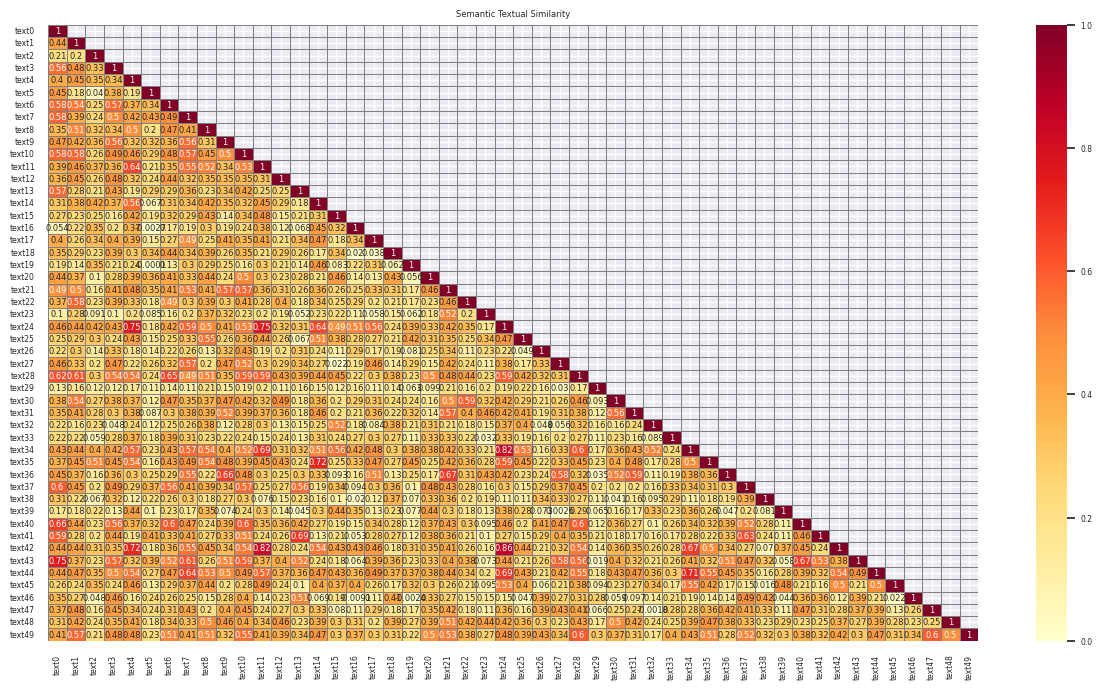

In [130]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
    sim = cosine_similarity_matrix(features)
    mask = np.triu(np.ones_like(sim, dtype=bool), k=1)

    plt.figure(figsize=(15, 8))
    sns.set_theme(font_scale=0.5)
    g = sns.heatmap(sim,
                 mask=mask,  # Aplica la m√°scara
                 xticklabels=['text'+str(it) for it, label in enumerate(labels)],
                 yticklabels=['text'+str(it) for it, label in enumerate(labels)],
                 vmin=0,
                 vmax=1,
                 cmap="YlOrRd",
                 annot=True,  # A√±ade los valores en las celdas
                #  fmt=".2f",  # Formato de los valores
                 linewidths=.5,  # A√±ade l√≠neas entre las celdas
                 linecolor='gray')  # Color de las l√≠neas
    g.set_xticklabels(['text'+str(it) for it, label in enumerate(labels)], rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    return g

plot_similarity(reviews, embeddings, 90)

In [131]:
dfTexto_Review = pd.DataFrame({'idTexto' : ['text'+str(it) for it, label in enumerate(reviews)], 'rewiew': reviews})
dfTexto_Review.head(20)

idTexto                                             rewiew
0    text0  spotify lately play music spotify app play bar...
1    text1  amazing one thing needed get premium cannot do...
2    text2                 easy use love suggested play lists
3    text3  new update trash tried play playlist played ra...
4    text4  good app lve army kpop fan listen song clearly...
5    text5  uninstalled app yet jre gets getting pushed ph...
6    text6  phone broken bought new one install spotify pl...
7    text7        worst playing songs automatically comes app
8    text8  would give 5 stars like music premium messed w...
9    text9  pushing 5 ads row often plays suggested songs ...
10  text10  app constantly freezes play section show music...
11  text11                                     best music app
12  text12  spotify removed last review said would use spo...
13  text13  buggy since last update playing bar dissapears...
14  text14  enjoy listening songs love time search songs l...
15  text15                            great app entire family
16  text16       easy use could add thing make podcast thanks
17  text17            display current song playing play songs
18  text18  used love app sure happened seriously gone hil...
19  text19  does't matter musical genre mood time suggesti...

In [132]:
dfTexto_Review[dfTexto_Review['idTexto'].isin(['text42', 'text24'])]

idTexto                         rewiew
24  text24       nice app listening songs
42  text42  one best apps listening music